In [1]:
import pandas as pd 
import numpy as np
import requests
import io
import csv
from path import Path
import psycopg2
from matplotlib import pyplot as plt
#from config import db_password

# Expand cols
pd.set_option('display.max_columns', 80)
pd.options.mode.chained_assignment = None

### CREATE DATASET

In [2]:
# Connction to AWS nba database
connection = psycopg2.connect(
    host = 'nba-db.cpmpsi1pfaz0.us-east-2.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = 'caf3rac3',
    database='postgres'
    )
cursor=connection.cursor()

In [3]:
#read in data from database for All NBA table
nba_unpivoted_sql = 'SELECT * FROM public.allnba_unpivoted'
All_NBA_Unpivoted_df = pd.read_sql(nba_unpivoted_sql, con=connection).drop(['Lg'],axis=1)
#rename the players column
All_NBA_Unpivoted_df=All_NBA_Unpivoted_df.rename(columns = {'Value':'PlayerName'})
#create column with the start year
All_NBA_Unpivoted_df['Season_Start_Year'] = All_NBA_Unpivoted_df['Season'].apply(lambda row: row[0:4])
All_NBA_Unpivoted_df['Season_Start_Year'] = pd.to_numeric(All_NBA_Unpivoted_df['Season_Start_Year'])
#All_NBA_Unpivoted_df.head(15)

In [4]:
#make dummies for position and team (1st, 2nd, 3rd)
All_NBA_Unpivoted_df = pd.get_dummies(All_NBA_Unpivoted_df,columns=['Position','Tm']).drop(['Season'],axis=1)
#rename the columns (cosmetic)
All_NBA_Unpivoted_df=All_NBA_Unpivoted_df.rename(columns = {'Position_C':'AllNBA_Center'})
All_NBA_Unpivoted_df=All_NBA_Unpivoted_df.rename(columns = {'Position_F':'AllNBA_Forward'})
All_NBA_Unpivoted_df=All_NBA_Unpivoted_df.rename(columns = {'Position_G':'AllNBA_Guard'})
#All_NBA_Unpivoted_df.head(10)

In [5]:
#get list of all of the players that have made an all nba team
AllNBAPlayersList = All_NBA_Unpivoted_df['PlayerName'].unique()
#AllNBAPlayersList

In [6]:
#read in data from database for season stats table
seasons_stats_sql = 'SELECT * FROM public.seasons_stats'
season_stats_df = pd.read_sql(seasons_stats_sql, con=connection)
#divid year into season start and end
season_stats_df=season_stats_df.rename(columns = {'Year':'Year_season_end'})
season_stats_df['Year_season_end'] = pd.to_numeric(season_stats_df['Year_season_end'])
season_stats_df['Year_season_start'] = (season_stats_df['Year_season_end'] - 1)
season_stats_df['Player'] = season_stats_df['Player'].apply(lambda row: row.replace("*",""))



In [7]:
# Make sure that the games played for 2021 is normalized to 82 games
# 72 games in 2021 
# 1998-1999 50 games
# 2011-2011 66 games

filename =  r'Stat_Glossary.xlsx'
stat_glossary = pd.read_excel(filename) 
scaled_stats = stat_glossary[stat_glossary.Scaled_Per_Game != 0].reset_index().drop(['index'], axis=1).Stat

def scale_stats_per_season(season_df, num_games, year):
    for stat in scaled_stats:
        season_df[stat].loc[season_df['Year_season_end']==year] = season_df[stat].loc[season_df['Year_season_end']==year] * 82/num_games
    return season_df


In [8]:
scale_stats_per_season(season_stats_df,50,1999)
scale_stats_per_season(season_stats_df,66,2012)
scale_stats_per_season(season_stats_df,75,2020)

,Year_season_end,Player,Pos,Age,Tm,G,GS,MP,PER,TS_pct,3PAr,FTr,ORB_pct,DRB_pct,TRB_pct,AST_pct,STL_pct,BLK_pct,TOV_pct,USG_pct,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG_pct,3P,3PA,3P_pct,2P,2PA,2P_pct,eFG_pct,FT,FTA,FT_pct,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year_season_start
0,2018,Álex Abrines,SG,24,OKC,75.000000,8.000000,1134.000000,9.0,0.567,0.759,0.158,2.5,8.9,5.6,3.4,1.7,0.6,7.4,12.7,1.300000,1.000000,2.200000,0.094,-1.9,0.4,-1.5,0.100000,115.000000,291.000000,0.395,84.000000,221.000000,0.380,31.000000,70.000000,0.443,0.540,39.000000,46.000000,0.848,26.000000,88.000000,114.000000,28.000000,38.000000,8.000000,25.000000,124.000000,353.000000,2017
1,2018,Quincy Acy,PF,27,BRK,70.000000,8.000000,1359.000000,8.2,0.525,0.800,0.164,3.1,17.1,10.0,6.0,1.2,1.6,13.3,14.4,-0.100000,1.100000,1.000000,0.036,-2.6,0.1,-2.5,-0.200000,130.000000,365.000000,0.356,102.000000,292.000000,0.349,28.000000,73.000000,0.384,0.496,49.000000,60.000000,0.817,40.000000,217.000000,257.000000,57.000000,33.000000,29.000000,60.000000,149.000000,411.000000,2017
2,2018,Steven Adams,C,24,OKC,76.000000,76.000000,2487.000000,20.6,0.630,0.003,0.402,16.6,13.9,15.3,5.5,1.8,2.8,13.3,16.7,6.700000,3.000000,9.700000,0.187,1.7,-0.6,1.1,2.000000,448.000000,712.000000,0.629,0.000000,2.000000,0.000,448.000000,710.000000,0.631,0.629,160.000000,286.000000,0.559,384.000000,301.000000,685.000000,88.000000,92.000000,78.000000,128.000000,215.000000,1056.000000,2017
3,2018,Bam Adebayo,C,20,MIA,69.000000,19.000000,1368.000000,15.7,0.570,0.021,0.526,9.7,21.6,15.6,11.0,1.2,2.5,13.6,15.9,2.300000,1.900000,4.200000,0.148,-1.1,0.7,-0.4,0.600000,174.000000,340.000000,0.512,0.000000,7.000000,0.000,174.000000,333.000000,0.523,0.512,129.000000,179.000000,0.721,118.000000,263.000000,381.000000,101.000000,32.000000,41.000000,66.000000,138.000000,477.000000,2017
4,2018,Arron Afflalo,SG,32,ORL,53.000000,3.000000,682.000000,5.8,0.516,0.432,0.160,0.6,10.1,5.3,6.2,0.3,1.1,10.8,12.5,-0.100000,0.200000,0.100000,0.009,-3.8,-1.5,-5.4,-0.600000,65.000000,162.000000,0.401,27.000000,70.000000,0.386,38.000000,92.000000,0.413,0.485,22.000000,26.000000,0.846,4.000000,62.000000,66.000000,30.000000,4.000000,9.000000,21.000000,56.000000,179.000000,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20945,2020,Trae Young,PG,21,ATL,65.600000,65.600000,2317.866667,23.9,0.595,0.455,0.448,1.6,11.5,6.5,45.6,1.4,0.3,16.2,34.9,5.794667,0.656000,6.450667,0.133,6.2,-2.3,3.9,3.389333,596.960000,1365.573333,0.437,224.133333,621.013333,0.361,372.826667,744.560000,0.501,0.519,525.893333,611.173333,0.860,34.986667,243.813333,278.800000,612.266667,71.066667,8.746667,315.973333,113.706667,1943.946667,2019
20946,2020,Cody Zeller,C,27,CHO,63.413333,42.640000,1466.160000,18.8,0.576,0.157,0.374,12.6,21.2,16.7,11.3,1.5,1.7,11.9,20.8,2.514667,1.421333,3.936000,0.129,0.2,-0.8,-0.6,0.546667,274.426667,523.706667,0.524,19.680000,82.000000,0.240,254.746667,441.706667,0.577,0.543,133.386667,195.706667,0.682,174.933333,274.426667,449.360000,96.213333,43.733333,27.333333,82.000000,153.066667,701.920000,2019
20947,2020,Tyler Zeller,C,30,SAS,2.186667,0.000000,4.373333,22.4,0.250,0.000,0.000,80.9,26.9,53.9,0.0,0.0,0.0,0.0,43.2,0.000000,0.000000,0.000000,-0.075,-0.3,-22.1,-22.4,0.000000,1.093333,4.373333,0.250,0.000000,0.000000,NaN,1.093333,4.373333,0.250,0.250,0.000000,0.000000,NaN,3.280000,1.093333,4.373333,0.000000,0.000000,0.000000,0.000000,0.000000,2.186667,2019
20948,2020,Ante Žižić,C,23,CLE,24.053333,0.000000,241.626667,16.4,0.597,0.000,0.264,9.0,24.4,16.6,4.2,1.5,1.9,11.1,17.5,0.328000,0.218667,0.546667,0.106,-1.7,-1.5,-3.2,-0.109333,44.826667,78.720000,0.569,0.000000,0.000000,NaN,44.826667,78.720000,0.569,0.569,15.306667,20.773333,0.737,19.680000,52.480000,72.160000,6.560000,7.653333,5.466667,10.933333,29.520000,104.960000,2019


In [9]:
# get list of every nba player
AllPlayersList = season_stats_df.Player.unique()
AllPlayersList_df = pd.DataFrame(AllPlayersList)

#check and make sure every all-nba player shows up in the season data dataset
for player in AllNBAPlayersList:
    if player not in AllPlayersList:   
        print(player)

In [10]:
#merge allNBA status into season stats
Season_Stats_ML_DF = pd.merge(season_stats_df,All_NBA_Unpivoted_df,how='left',left_on = ['Player','Year_season_start'], right_on = ['PlayerName','Season_Start_Year'])

In [11]:
# get rid of duplicate cols
Season_Stats_ML_DF = Season_Stats_ML_DF.drop(['Season_Start_Year','PlayerName'],axis=1)

In [12]:
# fill in zeros for players that arent all nba
Season_Stats_ML_DF['AllNBA_Center'] = Season_Stats_ML_DF['AllNBA_Center'].fillna(int(0))
Season_Stats_ML_DF['AllNBA_Forward'] = Season_Stats_ML_DF['AllNBA_Forward'].fillna(int(0))
Season_Stats_ML_DF['AllNBA_Guard'] = Season_Stats_ML_DF['AllNBA_Guard'].fillna(int(0))
Season_Stats_ML_DF['Tm_1st'] = Season_Stats_ML_DF['Tm_1st'].fillna(int(0))
Season_Stats_ML_DF['Tm_2nd'] = Season_Stats_ML_DF['Tm_2nd'].fillna(int(0))
Season_Stats_ML_DF['Tm_3rd'] = Season_Stats_ML_DF['Tm_3rd'].fillna(int(0))

In [13]:
#get list of positions
Positions_List = Season_Stats_ML_DF['Pos'].unique()
#Positions_List

In [14]:
# create functions to determine if player is a guard forward and/or center
def is_forward(pos):
    possible_pos = [ 'SF',  'PF', 'PF-C', 'SG-SF', 'PF-SF', 'SF-SG', 'SF-PF', 'C-PF', 'SG-PF', 'C-SF', 'PG-SF']
    if pos in possible_pos: isF = 1
    else: isF = 0
    return isF

def is_guard(pos):
    possible_pos = ['PG','SG','SG-SF','PG-SG','SG-PG','SF-SG','SG-PF','PG-SF']
    if pos in possible_pos: isG = 1
    else: isG = 0
    return isG

def is_center(pos):
    possible_pos = ['C','PF-C','C-PF','C-SF']
    if pos in possible_pos: isC = 1
    else: isC = 0
    return isC

In [15]:
#Create dummy columns for G, F, C
Season_Stats_ML_DF['is_Guard'] = Season_Stats_ML_DF['Pos'].apply(lambda pos: is_guard(pos) )
Season_Stats_ML_DF['is_Forward'] = Season_Stats_ML_DF['Pos'].apply(lambda pos: is_forward(pos) )
Season_Stats_ML_DF['is_Center'] = Season_Stats_ML_DF['Pos'].apply(lambda pos: is_center(pos) )

In [16]:
#Drop the Pos Column since we have dummy columns
Season_Stats_ML_DF=Season_Stats_ML_DF.drop(['Pos'],axis=1)

In [17]:
# drop year  and player name
Season_Stats_ML_DF=Season_Stats_ML_DF.drop(['Year_season_end','Player'],axis=1)
Season_Stats_ML_DF=Season_Stats_ML_DF.drop(['Year_season_start'],axis=1)

In [18]:
#Creating Per Game Statistics

#Points per Game
Season_Stats_ML_DF["PPG"] = Season_Stats_ML_DF["PTS"]/Season_Stats_ML_DF["G"]
#Assits Per Game
Season_Stats_ML_DF["APG"] = Season_Stats_ML_DF["AST"]/Season_Stats_ML_DF["G"]
#Rebounds Per Game
Season_Stats_ML_DF["RPG"] = Season_Stats_ML_DF["TRB"]/Season_Stats_ML_DF["G"]
#Blocks Per Game
Season_Stats_ML_DF["RPG"] = Season_Stats_ML_DF["BLK"]/Season_Stats_ML_DF["G"]
#STLs Per Game
Season_Stats_ML_DF["SPG"] = Season_Stats_ML_DF["STL"]/Season_Stats_ML_DF["G"]

In [19]:
Season_Stats_ML_DF['3PAr'] = Season_Stats_ML_DF['3PAr'].fillna(int(0))
Season_Stats_ML_DF['3P'] = Season_Stats_ML_DF['3P'].fillna(int(0))
Season_Stats_ML_DF['3PA'] = Season_Stats_ML_DF['3PA'].fillna(int(0))
Season_Stats_ML_DF['3P_pct'] = Season_Stats_ML_DF['3P_pct'].fillna(int(0))


In [20]:
# Fill null values with zero
for col in list(Season_Stats_ML_DF.columns):
    Season_Stats_ML_DF[col] = Season_Stats_ML_DF[col].fillna(int(0))

### ALL NBA CENTER MACHINE LEARNING SECTION

In [21]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=78)

X = Season_Stats_ML_DF[Season_Stats_ML_DF.is_Center==1]
X = X.drop(['AllNBA_Center','AllNBA_Forward','AllNBA_Guard','is_Guard','is_Center','is_Forward','WS/48','STL_pct','APG','GS'], axis=1)
X = X.drop(['Tm','Tm_1st','Tm_2nd','Tm_3rd'], axis=1)

y = Season_Stats_ML_DF[Season_Stats_ML_DF.is_Center==1]
y = y["AllNBA_Center"].values.reshape(-1, 1)

# Splitting into Train and Test sets
# Creating StandardScaler instance
# Fitting Standard Scaller
# Scaling data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

#oversampling
X_train, y_train = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_Center_Train = X_train

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier(max_depth=20)

center_model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = center_model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix Centers")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix Centers


,Predicted 0,Predicted 1
Actual 0,1007,13
Actual 1,10,21


Accuracy Score : 0.978116079923882
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1020
         1.0       0.62      0.68      0.65        31

    accuracy                           0.98      1051
   macro avg       0.80      0.83      0.82      1051
weighted avg       0.98      0.98      0.98      1051



In [22]:
# Sort the features by their importance.
importances =center_model.feature_importances_
center_feature_importance = sorted(zip(center_model.feature_importances_, X.columns), reverse=True)
center_feature_importance

[(0.7548739845474153, 'WS'),
 (0.06908622590425433, 'FTA'),
 (0.04126865464187064, 'TRB'),
 (0.030079562896250668, 'Age'),
 (0.029697936327617212, 'RPG'),
 (0.019050129275183365, 'BLK_pct'),
 (0.01212244346996873, 'PER'),
 (0.008131821092126722, 'TOV'),
 (0.006718418080990242, 'TS_pct'),
 (0.006446229478856331, 'BPM'),
 (0.003760738724617836, 'MP'),
 (0.0031672363171128108, 'AST'),
 (0.002555399959226172, 'FTr'),
 (0.002516787257079124, 'DWS'),
 (0.0019278928736718355, '2P'),
 (0.0018933364233336722, 'FT'),
 (0.0012847169110687367, 'FG'),
 (0.0012690841432602658, '3PA'),
 (0.0008708196075441289, 'eFG_pct'),
 (0.0006529855226347552, 'OBPM'),
 (0.000643744444333376, 'DRB'),
 (0.0006432244568986208, 'AST_pct'),
 (0.0006421863703489902, 'PPG'),
 (0.0006416682692030377, 'PF'),
 (5.47730051330273e-05, 'USG_pct'),
 (0.0, 'VORP'),
 (0.0, 'TRB_pct'),
 (0.0, 'TOV_pct'),
 (0.0, 'STL'),
 (0.0, 'SPG'),
 (0.0, 'PTS'),
 (0.0, 'OWS'),
 (0.0, 'ORB_pct'),
 (0.0, 'ORB'),
 (0.0, 'G'),
 (0.0, 'FT_pct'),
 (

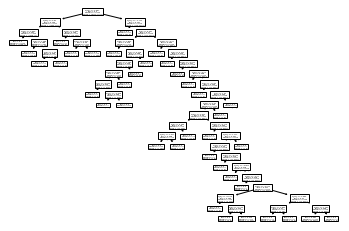

The center tree has a depth of 20 with 75 nodes.


In [23]:
tree.plot_tree(center_model)
plt.show()
center_tree_n_count = center_model.tree_.node_count
center_tree_depth = center_model.get_depth()
print(f'The center tree has a depth of {center_tree_depth} with {center_tree_n_count} nodes.')

### ALL NBA GUARD MACHINE LEARNING SECTION

In [24]:
X = Season_Stats_ML_DF[Season_Stats_ML_DF.is_Guard==1]
X = X.drop(['AllNBA_Center','AllNBA_Forward','AllNBA_Guard','is_Guard','is_Center','is_Forward','WS/48','STL_pct','APG','GS'], axis=1)
X = X.drop(['Tm','Tm_1st','Tm_2nd','Tm_3rd'], axis=1)

y = Season_Stats_ML_DF[Season_Stats_ML_DF.is_Guard==1]
y = y["AllNBA_Guard"].values.reshape(-1, 1)

# Splitting into Train and Test sets
# Creating StandardScaler instance
# Fitting Standard Scaller
# Scaling data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

#oversampling
X_train, y_train = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_Guard_Train = X_train
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier(max_depth=25, random_state=78)

guard_model = model.fit(X_train_scaled, y_train)


# Making predictions using the testing data
predictions = guard_model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,2028,27
Actual 1,17,35


Accuracy Score : 0.9791172282866635
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2055
         1.0       0.56      0.67      0.61        52

    accuracy                           0.98      2107
   macro avg       0.78      0.83      0.80      2107
weighted avg       0.98      0.98      0.98      2107



In [25]:
# Sort the features by their importance.
importances =guard_model.feature_importances_
guard_feature_importance = sorted(zip(guard_model.feature_importances_, X.columns), reverse=True)
guard_feature_importance

[(0.8432685147662676, 'WS'),
 (0.045282126786751864, 'PPG'),
 (0.013355874414302926, 'PER'),
 (0.011785034266988664, 'DRB_pct'),
 (0.011241553905530497, '3PAr'),
 (0.010006663819445653, 'DRB'),
 (0.006078977712965507, 'FT'),
 (0.005351503209024523, 'Age'),
 (0.005035323492048779, 'AST_pct'),
 (0.004900313321930378, 'TOV'),
 (0.0038229514591904823, 'DWS'),
 (0.0033184055212823475, 'MP'),
 (0.0032302495118990853, 'FT_pct'),
 (0.003083524405247311, 'ORB_pct'),
 (0.002976653482588358, 'USG_pct'),
 (0.00288890271537461, 'FTr'),
 (0.0026852366677606867, 'G'),
 (0.0025792836534454886, 'FG'),
 (0.002494135270476092, 'VORP'),
 (0.002123647653629198, 'FG_pct'),
 (0.002049735836033535, '2P_pct'),
 (0.0018859999389401838, 'PF'),
 (0.0015544377394345603, 'PTS'),
 (0.0015298522919644482, 'OBPM'),
 (0.0015295139097998647, 'OWS'),
 (0.0012674716145031563, 'DBPM'),
 (0.001208794849473106, 'BPM'),
 (0.000958360067040723, '3P_pct'),
 (0.0009078895245675199, '2P'),
 (0.000636302312305623, 'SPG'),
 (0.0006

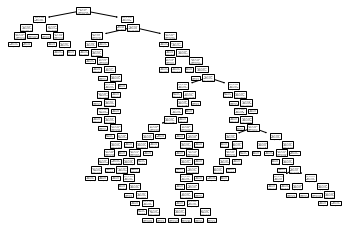

The guard tree has a depth of 25 with 167 nodes.


In [26]:
tree.plot_tree(guard_model)
plt.show()
guard_tree_n_count = guard_model.tree_.node_count
guard_tree_depth = guard_model.get_depth()
print(f'The guard tree has a depth of {guard_tree_depth} with {guard_tree_n_count} nodes.')

### ALL NBA FORWARD MACHINE LEARNING SECTION

In [27]:
X = Season_Stats_ML_DF[Season_Stats_ML_DF.is_Forward==1]
X = X.drop(['AllNBA_Center','AllNBA_Forward','AllNBA_Guard','is_Guard','is_Center','is_Forward','WS/48','STL_pct','APG','GS'], axis=1)
X = X.drop(['Tm','Tm_1st','Tm_2nd','Tm_3rd'], axis=1)

y = Season_Stats_ML_DF[Season_Stats_ML_DF.is_Forward==1]
y = y["AllNBA_Forward"].values.reshape(-1, 1)

# Splitting into Train and Test sets
# Creating StandardScaler instance
# Fitting Standard Scaller
# Scaling data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

#oversampling
X_train, y_train = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_Forward_Train = X_train
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier(max_depth=19, random_state=78)

forward_model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = forward_model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix Forwards")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix Forwards


,Predicted 0,Predicted 1
Actual 0,2030,27
Actual 1,16,38


Accuracy Score : 0.9796305068687826
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2057
         1.0       0.58      0.70      0.64        54

    accuracy                           0.98      2111
   macro avg       0.79      0.85      0.81      2111
weighted avg       0.98      0.98      0.98      2111



In [28]:
# We can sort the features by their importance.
importances = forward_model.feature_importances_
forward_feature_importance = sorted(zip(forward_model.feature_importances_, X.columns), reverse=True)
forward_feature_importance

[(0.8523159553328726, 'PPG'),
 (0.03785815903608333, 'VORP'),
 (0.03323399732476884, 'WS'),
 (0.010066094234952003, 'PER'),
 (0.00870157333675098, 'TRB_pct'),
 (0.007784614108988051, 'FTr'),
 (0.007394330037915377, 'DRB_pct'),
 (0.004962794461868405, 'DWS'),
 (0.004902449063022736, 'AST_pct'),
 (0.00446981614393297, 'MP'),
 (0.004340082581789716, 'PF'),
 (0.004039194046481523, 'BPM'),
 (0.0030142981898555973, 'FT_pct'),
 (0.002559991914845499, 'ORB'),
 (0.002471339914299481, '3P_pct'),
 (0.0021873540424864864, 'Age'),
 (0.0020007760547003893, 'TOV'),
 (0.0019433581762172858, '3PA'),
 (0.001291453025186343, '2PA'),
 (0.0011709868271125203, '3PAr'),
 (0.0009124026605938413, 'FTA'),
 (0.0006464924989663689, 'AST'),
 (0.00032433520354652087, 'TRB'),
 (0.00032420680481188197, 'BLK_pct'),
 (0.00032395023597597724, 'FGA'),
 (0.0003125280575687016, '2P_pct'),
 (0.00031175062458969985, 'ORB_pct'),
 (0.00013571605981684465, 'SPG'),
 (0.0, 'eFG_pct'),
 (0.0, 'USG_pct'),
 (0.0, 'TS_pct'),
 (0.0, '

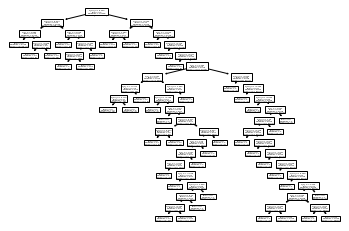

The foward tree has a depth of 19 with 87 nodes.


In [29]:
tree.plot_tree(forward_model)
plt.show()
forward_tree_n_count = forward_model.tree_.node_count
forward_tree_depth = forward_model.get_depth()
print(f'The foward tree has a depth of {forward_tree_depth} with {forward_tree_n_count} nodes.')

### PREDICTIONS

In [30]:
testing_stats_sql = 'SELECT * FROM public.testing_stats'
seasons_stats_2021 = pd.read_sql(testing_stats_sql, con=connection)

#Points per Game
seasons_stats_2021["PPG"] = seasons_stats_2021["PTS"]/seasons_stats_2021["G"]
#Assits Per Game
seasons_stats_2021["APG"] = seasons_stats_2021["AST"]/seasons_stats_2021["G"]
#Rebounds Per Game
seasons_stats_2021["RPG"] = seasons_stats_2021["TRB"]/seasons_stats_2021["G"]
#Blocks Per Game
seasons_stats_2021["RPG"] = seasons_stats_2021["BLK"]/seasons_stats_2021["G"]
#STLs Per Game
seasons_stats_2021["SPG"] = seasons_stats_2021["STL"]/seasons_stats_2021["G"]    

In [31]:
# Scale stats for shortened season
def scale_stats(season_df, num_games):
    #scaled_season_df = pd.DataFrame()
    for stat in scaled_stats:
        season_df[stat] = season_df[stat] * 82/num_games
    return season_df

seasons_stats_2021 = scale_stats(seasons_stats_2021,72)

In [32]:
centers_stats_2021 = seasons_stats_2021
forwards_stats_2021 = seasons_stats_2021
guards_stats_2021 = seasons_stats_2021

centers_stats_2021['is_Center'] = centers_stats_2021['Pos'].apply(lambda pos: is_center(pos) )
guards_stats_2021['is_Guard'] = guards_stats_2021['Pos'].apply(lambda pos: is_guard(pos) )
forwards_stats_2021['is_Forward'] = forwards_stats_2021['Pos'].apply(lambda pos: is_forward(pos) )

centers_stats_2021=centers_stats_2021[centers_stats_2021['is_Center']==1]
guards_stats_2021=guards_stats_2021[guards_stats_2021['is_Guard']==1]
forwards_stats_2021=forwards_stats_2021[forwards_stats_2021['is_Forward']==1]

centers_stats_2021=centers_stats_2021[centers_stats_2021['is_Center']==1].reset_index()
guards_stats_2021=guards_stats_2021[guards_stats_2021['is_Guard']==1].reset_index()
forwards_stats_2021=forwards_stats_2021[forwards_stats_2021['is_Forward']==1].reset_index()


In [33]:
#Predict All- nba Centers
X_scaler = StandardScaler().fit(X_Center_Train)
X_test_scaled = X_scaler.transform(centers_stats_2021[['Age','G','MP','PER','TS_pct','3PAr','FTr','ORB_pct',
                                                       'DRB_pct','TRB_pct','AST_pct','BLK_pct',
                                                       'TOV_pct','USG_pct','OWS', 'DWS','WS','OBPM',
                                                       'DBPM','BPM','VORP','FG','FGA','FG_pct','3P',
                                                       '3PA','3P_pct','2P','2PA','2P_pct','eFG_pct',
                                                       'FT','FTA','FT_pct','ORB','DRB','TRB','AST',
                                                       'STL','BLK','TOV','PF','PTS','PPG','RPG','SPG']])
X_test_scaled = np.nan_to_num(X_test_scaled)
predictions = center_model.predict(X_test_scaled)
predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.rename(columns = {predictions_df.columns[0]:'All_NBA_Status'})
centers_stats_2021=centers_stats_2021.join(predictions_df)
# List All NBA team players in order of feature importance
centers_stats_2021[centers_stats_2021.All_NBA_Status == 1].sort_values(by=['WS','DWS','PER','RPG','TOV','TRB'],ascending=False).head(3)

,index,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS_pct,3PAr,FTr,ORB_pct,DRB_pct,TRB_pct,AST_pct,STL_pct,BLK_pct,TOV_pct,USG_pct,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG_pct,3P,3PA,3P_pct,2P,2PA,2P_pct,eFG_pct,FT,FTA,FT_pct,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PPG,APG,RPG,SPG,is_Center,is_Guard,is_Forward,All_NBA_Status
70,343,2021,Nikola Jokić,C,25,DEN,82.000000,82.000000,2833.555556,31.3,0.647,0.183,0.305,9.4,26.1,17.8,40.4,1.9,1.9,13.1,29.6,13.894444,3.872222,17.766667,0.301,9.2,2.5,11.7,9.794444,833.666667,1472.583333,0.566,104.777778,269.916667,0.388,728.888889,1202.666667,0.606,0.602,389.500000,448.722222,0.868,233.472222,654.861111,888.333333,682.194444,108.194444,54.666667,252.833333,218.666667,2161.611111,26.361111,8.319444,0.666667,1.319444,1,0,0,1.0
56,228,2021,Rudy Gobert,C,28,UTA,80.861111,80.861111,2490.750000,23.5,0.683,0.007,0.646,12.2,33.5,23.3,6.0,0.9,7.0,13.7,17.0,6.947222,5.922222,12.869444,0.248,2.0,2.5,4.5,4.100000,445.305556,659.416667,0.675,0.000000,4.555556,0.000,445.305556,654.861111,0.680,0.675,265.361111,425.944444,0.623,273.333333,820.000000,1093.333333,101.361111,45.555556,216.388889,134.388889,185.638889,1155.972222,14.295775,1.253521,2.676056,0.563380,1,0,0,1.0
1,3,2021,Bam Adebayo,C,23,MIA,72.888889,72.888889,2440.638889,22.7,0.626,0.010,0.443,7.7,22.6,15.3,26.9,1.7,3.2,15.0,23.7,6.377778,3.644444,10.022222,0.197,2.9,1.9,4.7,4.100000,519.333333,911.111111,0.570,2.277778,9.111111,0.250,517.055556,902.000000,0.573,0.571,322.305556,403.166667,0.799,161.722222,490.861111,652.583333,394.055556,85.416667,75.166667,192.472222,165.138889,1363.250000,18.703125,5.406250,1.031250,1.171875,1,0,0,1.0


In [34]:
#Predict All- nba Guards
X_scaler = StandardScaler().fit(X_Guard_Train)
X_test_scaled = X_scaler.transform(guards_stats_2021[['Age','G','MP','PER','TS_pct','3PAr','FTr','ORB_pct',
                                                      'DRB_pct','TRB_pct','AST_pct','BLK_pct','TOV_pct','USG_pct',
                                                      'OWS', 'DWS','WS','OBPM','DBPM','BPM','VORP','FG','FGA',
                                                      'FG_pct','3P','3PA','3P_pct','2P','2PA','2P_pct','eFG_pct',
                                                      'FT','FTA','FT_pct','ORB','DRB','TRB','AST','STL','BLK',
                                                      'TOV','PF','PTS','PPG','RPG','SPG']])
X_test_scaled = np.nan_to_num(X_test_scaled)
predictions = guard_model.predict(X_test_scaled)
predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.rename(columns = {predictions_df.columns[0]:'All_NBA_Status'})
guards_stats_2021=guards_stats_2021.join(predictions_df)
# List All NBA team players in order of feature importance
guards_stats_2021[guards_stats_2021.All_NBA_Status == 1].sort_values(by=['WS','PPG','PER','3PAr','DRB_pct','DRB','FT'],ascending=False).head(6)

,index,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS_pct,3PAr,FTr,ORB_pct,DRB_pct,TRB_pct,AST_pct,STL_pct,BLK_pct,TOV_pct,USG_pct,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG_pct,3P,3PA,3P_pct,2P,2PA,2P_pct,eFG_pct,FT,FTA,FT_pct,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PPG,APG,RPG,SPG,is_Center,is_Guard,is_Forward,All_NBA_Status
50,151,2021,Stephen Curry,PG,32,GSW,71.750000,71.750000,2450.888889,26.3,0.655,0.587,0.289,1.5,15.4,8.5,30.5,1.7,0.3,12.2,34.8,7.402778,2.847222,10.250000,0.201,8.1,0.0,8.1,6.263889,749.388889,1554.583333,0.482,383.805556,912.250000,0.421,365.583333,642.333333,0.569,0.605,412.277778,449.861111,0.916,33.027778,359.888889,392.916667,413.416667,87.694444,9.111111,242.583333,135.527778,2294.861111,31.984127,5.761905,0.126984,1.222222,0,1,0,1.0
60,171,2021,Luka Dončić,PG,21,DAL,75.166667,75.166667,2576.166667,25.3,0.587,0.406,0.349,2.7,22.9,12.8,44.1,1.4,1.5,15.3,36.0,5.808333,2.961111,8.769444,0.163,6.1,0.6,6.7,5.694444,736.861111,1538.638889,0.479,218.666667,624.111111,0.350,518.194444,914.527778,0.567,0.550,391.777778,536.416667,0.730,61.500000,538.694444,600.194444,645.750000,72.888889,41.000000,320.027778,173.111111,2084.166667,27.727273,8.590909,0.545455,0.969697,0,1,0,1.0
124,316,2021,Kyrie Irving,PG,28,BRK,61.500000,61.500000,2147.944444,24.4,0.614,0.348,0.201,3.2,11.4,7.5,28.6,1.9,1.7,9.9,30.4,6.605556,1.822222,8.427778,0.189,5.7,-0.4,5.3,3.986111,625.250000,1236.833333,0.506,173.111111,430.500000,0.402,452.138889,806.333333,0.561,0.576,228.916667,248.277778,0.922,59.222222,233.472222,292.694444,369.000000,86.555556,42.138889,148.055556,159.444444,1652.527778,26.870370,6.000000,0.685185,1.407407,0,1,0,1.0
297,702,2021,Trae Young,PG,22,ATL,71.750000,71.750000,2420.138889,23.0,0.589,0.357,0.491,2.0,10.5,6.3,45.5,1.2,0.5,16.2,33.0,6.719444,1.480556,8.200000,0.163,5.4,-1.7,3.6,3.416667,554.638889,1266.444444,0.438,154.888889,452.138889,0.343,399.750000,814.305556,0.491,0.499,551.222222,621.833333,0.886,43.277778,235.750000,279.027778,676.500000,60.361111,13.666667,297.250000,126.416667,1815.388889,25.301587,9.428571,0.190476,0.841270,0,1,0,1.0
181,453,2021,Donovan Mitchell,PG,24,UTA,60.361111,60.361111,2016.972222,21.3,0.569,0.423,0.290,3.1,10.6,7.0,26.7,1.4,0.7,10.7,33.5,4.441667,2.505556,7.061111,0.167,4.1,-0.6,3.5,2.847222,544.388889,1242.527778,0.438,202.722222,525.027778,0.386,341.666667,717.500000,0.476,0.520,304.083333,359.888889,0.845,56.944444,210.694444,267.638889,315.472222,59.222222,17.083333,167.416667,133.250000,1595.583333,26.433962,5.226415,0.283019,0.981132,0,1,0,1.0
149,381,2021,Zach LaVine,SG,25,CHI,66.055556,66.055556,2316.500000,21.5,0.634,0.425,0.265,2.0,13.6,7.9,23.4,1.1,1.2,13.9,31.0,4.555556,2.050000,6.719444,0.138,4.8,-1.1,3.7,3.302778,648.027778,1278.972222,0.507,227.777778,543.250000,0.419,420.250000,735.722222,0.571,0.596,288.138889,339.388889,0.849,41.000000,288.138889,329.138889,321.166667,52.388889,30.750000,231.194444,157.166667,1811.972222,27.431034,4.862069,0.465517,0.793103,0,1,0,1.0


In [35]:
#Predict All- nba Forwards
X_scaler = StandardScaler().fit(X_Forward_Train)
X_test_scaled = X_scaler.transform(forwards_stats_2021[['Age','G','MP','PER','TS_pct','3PAr','FTr','ORB_pct','DRB_pct',
                                                        'TRB_pct','AST_pct','BLK_pct','TOV_pct','USG_pct','OWS', 'DWS',
                                                        'WS','OBPM','DBPM','BPM','VORP','FG','FGA','FG_pct','3P','3PA',
                                                        '3P_pct','2P','2PA','2P_pct','eFG_pct','FT','FTA','FT_pct','ORB',
                                                        'DRB','TRB','AST','STL','BLK','TOV','PF','PTS','PPG','RPG','SPG']])
X_test_scaled = np.nan_to_num(X_test_scaled)
predictions = forward_model.predict(X_test_scaled)
predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.rename(columns = {predictions_df.columns[0]:'All_NBA_Status'})
forwards_stats_2021=forwards_stats_2021.join(predictions_df)
# List All NBA team players in order of feature importance
forwards_stats_2021[forwards_stats_2021.All_NBA_Status == 1].sort_values(by=['PPG','VORP','WS','PER','TRB_pct','FTr','DWS'],ascending=False).head(6)

,index,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS_pct,3PAr,FTr,ORB_pct,DRB_pct,TRB_pct,AST_pct,STL_pct,BLK_pct,TOV_pct,USG_pct,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG_pct,3P,3PA,3P_pct,2P,2PA,2P_pct,eFG_pct,FT,FTA,FT_pct,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PPG,APG,RPG,SPG,is_Center,is_Guard,is_Forward,All_NBA_Status
5,17,2021,Giannis Antetokounmpo,PF,26,MIL,69.472222,69.472222,2292.583333,29.2,0.633,0.201,0.528,5.3,28.9,17.5,28.7,1.7,3.2,13.2,32.5,7.858333,3.758333,11.616667,0.244,6.2,2.6,8.8,6.263889,712.944444,1252.777778,0.569,76.305556,251.694444,0.303,636.638889,1001.083333,0.636,0.600,453.277778,661.694444,0.685,110.472222,653.722222,764.194444,406.583333,82.000000,83.138889,235.750000,191.333333,1955.472222,28.147541,5.852459,1.196721,1.180328,0,0,1,1.0
266,688,2021,Zion Williamson,PF,20,NOP,69.472222,69.472222,2307.388889,27.1,0.649,0.033,0.510,8.9,14.7,11.8,19.7,1.3,1.8,11.6,29.8,8.086111,1.822222,9.908333,0.205,5.8,-0.4,5.4,4.327778,722.055556,1181.027778,0.611,11.388889,38.722222,0.294,710.666667,1142.305556,0.622,0.616,420.250000,602.472222,0.698,190.194444,312.055556,502.250000,257.388889,64.916667,44.416667,190.194444,153.750000,1875.750000,27.000000,3.704918,0.639344,0.934426,0,0,1,1.0
244,610,2021,Jayson Tatum,SF,22,BOS,72.888889,72.888889,2608.055556,21.3,0.576,0.368,0.258,2.4,20.7,11.5,20.3,1.6,1.3,10.4,30.8,4.669444,2.847222,7.402778,0.137,4.1,-0.4,3.7,3.758333,689.027778,1501.055556,0.459,212.972222,552.361111,0.386,476.055556,948.694444,0.502,0.530,335.972222,387.222222,0.868,56.944444,480.611111,537.555556,314.333333,85.416667,35.305556,194.750000,138.944444,1927.000000,26.437500,4.312500,0.484375,1.171875,0,0,1,1.0
158,390,2021,Kawhi Leonard,SF,29,LAC,59.222222,59.222222,2019.250000,26.0,0.622,0.280,0.325,3.6,17.4,10.7,24.9,2.3,1.1,9.2,28.6,7.288889,2.733333,10.022222,0.238,5.7,1.0,6.7,4.441667,529.583333,1034.111111,0.512,115.027778,289.277778,0.398,414.555556,744.833333,0.557,0.568,297.250000,335.972222,0.885,62.638889,321.166667,383.805556,306.361111,92.250000,23.916667,119.583333,93.388889,1471.444444,24.846154,5.173077,0.403846,1.557692,0,0,1,1.0
221,544,2021,Julius Randle,PF,26,NYK,80.861111,80.861111,3037.416667,19.7,0.567,0.294,0.325,3.5,25.7,14.7,27.2,1.2,0.6,13.8,29.3,3.872222,4.897222,8.883333,0.140,3.0,0.7,3.7,4.327778,685.611111,1504.472222,0.456,182.222222,443.027778,0.411,503.388889,1061.444444,0.474,0.516,396.333333,488.583333,0.811,95.666667,727.750000,823.416667,486.305556,72.888889,20.500000,274.472222,256.250000,1949.777778,24.112676,6.014085,0.253521,0.901408,0,0,1,1.0
44,106,2021,Jimmy Butler,SF,31,MIA,59.222222,59.222222,1987.361111,26.5,0.607,0.139,0.565,6.3,17.1,11.8,35.1,3.1,1.1,10.6,26.6,7.516667,3.075000,10.591667,0.255,5.1,2.5,7.5,4.783333,416.833333,838.222222,0.497,28.472222,116.166667,0.245,388.361111,722.055556,0.538,0.514,408.861111,473.777778,0.863,107.055556,301.805556,408.861111,420.250000,123.000000,20.500000,124.138889,80.861111,1271.000000,21.461538,7.096154,0.346154,2.076923,0,0,1,1.0
